# Horizontal flip, vertical flip, coordinate flip, rotation.

In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, Aer
from qiskit import transpile, assemble
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
import math

### Image generating

In [24]:
image = np.random.uniform(low=0, high=255, size=(2,2)).astype(int)
input_im = image.copy().flatten()
input_im = np.interp(input_im, (0, 255), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

In [25]:
def simulate(qc, input_im, shots=10000, print_data=True):    
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=shots)
    result = aer_sim.run(qobj).result()
    counts = result.get_counts(qc)
    if print_data:
        print(counts)
        plot_histogram(counts)
        plt.show()
    nums = []
    for iter in range(len(input_im)):
        num = []
        for item in counts.items():
            if int(item[0][1:], 2)==iter:
                num.append((int(item[0][0], 2), item[1]))
        nums.append(num)
    colors = []
    for num in nums:
        if len(num)==2:
            if num[0][0] == 0:
                color = np.arccos((num[0][1]/(num[0][1]+num[1][1]))**(1/2))
                colors.append(color)
            else:
                color = np.arccos((num[1][1]/(num[0][1]+num[1][1]))**(1/2))
                colors.append(color)
        else:
            if num[0][0] == 0:
                colors.append(0)
            else:
                colors.append(np.pi/2)
    output_im = np.interp(colors, (0, np.pi/2), (0, 255)).astype(int)
    print(output_im, '\n', image.copy().flatten())
    return output_im

def plot_to_compare(output_im, input_im):
    plt.imshow(output_im.reshape(2,2), cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im.reshape(2,2), cmap = 'gray')
    plt.title('real image')
    plt.show()

### Vertical flipping

In [26]:
color = QuantumRegister(1, 'color')
coordinate = QuantumRegister(2, 'coordinate')
cr = ClassicalRegister(3, 'c')
qc = QuantumCircuit(coordinate,color, cr)
qc.h(0)
qc.h(1)
qc.swap(0,1)
for i, pixel in enumerate(input_im):
    to_not = "{0:b}".format(i).zfill(2)
    for j, bit in enumerate(to_not):
        if int(bit):
            qc.x(j)
    if to_not[0]:
        qc.x(0)
    qc.cry(pixel,0,2)
    qc.cx(0,1)
    qc.cry(-pixel,1,2)
    qc.cx(0,1)
    qc.cry(pixel,1,2)
    for j, bit in enumerate(to_not):
        if int(bit):
            qc.x(j)
    if to_not[0]:
        qc.x(0)
        qc.barrier()
qc.swap(0,1)
for i in range(len(input_im)-1):
    qc.measure(i, i)

The operation flips pixels along Y-axis. Certain values of the each pixel of classical and quantum flipped representation are in the vector

[255 131 168  74] 
 [131 254  77 168]


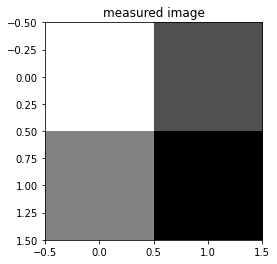

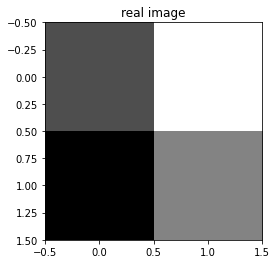

In [27]:
output_im = simulate(qc, input_im, print_data=False)
plot_to_compare(output_im, input_im)

### Horizontal flip

In [28]:
color = QuantumRegister(1, 'color')
coordinate = QuantumRegister(2, 'coordinate')
cr = ClassicalRegister(3, 'c')
qc = QuantumCircuit(coordinate,color, cr)
qc.h(0)
qc.h(1)
qc.swap(0,1)
for i, pixel in enumerate(input_im):
    to_not = "{0:b}".format(i).zfill(2)
    for j, bit in enumerate(to_not):
        if int(bit):
            qc.x(j)
    if to_not[1]:
        qc.x(1)
    qc.cry(pixel,0,2)
    qc.cx(0,1)
    qc.cry(-pixel,1,2)
    qc.cx(0,1)
    qc.cry(pixel,1,2)
    for j, bit in enumerate(to_not):
        if int(bit):
            qc.x(j)
    if to_not[1]:
        qc.x(1)
        qc.barrier()
qc.swap(0,1)
for i in range(len(input_im)-1):
    qc.measure(i, i)

The operation flips pixels along X-axis. Certain values of the each pixel of classical and quantum flipped representation are in the vector

[ 77 167 129 255] 
 [131 254  77 168]


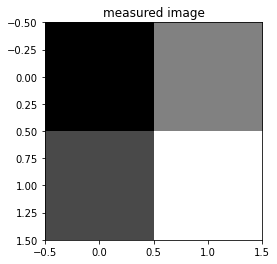

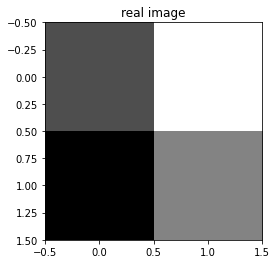

In [29]:
output_im = simulate(qc, input_im, 10000, print_data=False)
plot_to_compare(output_im, input_im)

### Let me take bigger image for the next processing operation
multicontrol rotation from https://arxiv.org/pdf/quant-ph/9503016.pdf

workable solution is from https://github.com/Qiskit/qiskit-terra/issues/5810

In [30]:
image = np.array([0, 0, 0, 0,
                  250, 200, 150, 100,
                  0, 0, 50, 0,
                  0, 0, 0, 0]).reshape(4,4)
input_im = image.flatten()
input_im = np.interp(input_im, (0, 255), (0, np.pi/2))

In [31]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im.reshape(4,4), cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im.reshape(4,4), cmap = 'gray')
    plt.title('real image')
    plt.show()

Rotation circuit

In [32]:
from qiskit.circuit.library.standard_gates.ry import RYGate
def rotate_circ(rot_ang=None):
    qr = QuantumRegister(5)
    cr = ClassicalRegister(5, 'c')
    qc = QuantumCircuit(qr, cr)
            
    qc.swap(0,3)
    qc.swap(1,2)

    for i in range(4):
        qc.h(i)
        
    for i, pixel in enumerate(input_im):
        to_not = "{0:b}".format(i).zfill(4)
        for j, bit in enumerate(to_not):
            if int(bit):
                qc.x(j)
        qc.barrier()
        
        c3ry = RYGate(2*pixel).control(4)
        qc.append(c3ry, [0, 1, 2, 3, 4])    

        if i!=len(input_im)-1:
            for j, bit in enumerate(to_not):
                if int(bit):
                    qc.x(j)
            qc.barrier()

    qc.swap(0,3)
    qc.swap(1,2)
    
    if rot_ang == 90:
        qc.x(2)
        qc.x(3)
        qc.swap(0,3)
        qc.swap(1,2)
        
    if rot_ang == 180:
        qc.x(0)
        qc.x(1)
        qc.x(2)
        qc.x(3)
              
    if rot_ang == 270:
        qc.swap(0,3)
        qc.swap(1,2)
        qc.x(2)
        qc.x(3)
        
    for i in range(5):
        qc.measure(i, i)
        
    return qc

We can realize rotation of 3 different angles. Let us try each of them:

ROTATION FOR 90 DEGREES


[  0 249   0   0   0 151  52   0   0 201   0   0   0 100   0   0] 
 [  0   0   0   0 250 200 150 100   0   0  50   0   0   0   0   0]


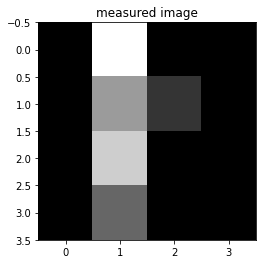

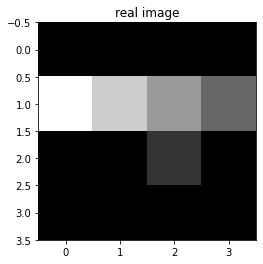

ROTATION FOR 180 DEGREES


[  0   0   0   0   0  50   0   0  98 150 199 251   0   0   0   0] 
 [  0   0   0   0 250 200 150 100   0   0  50   0   0   0   0   0]


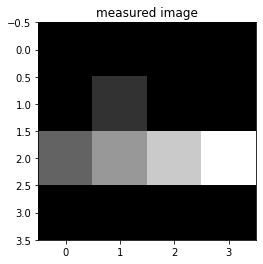

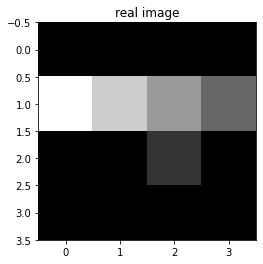

ROTATION FOR 270 DEGREES


[  0   0  99   0   0   0 200   0   0  49 151   0   0   0 251   0] 
 [  0   0   0   0 250 200 150 100   0   0  50   0   0   0   0   0]


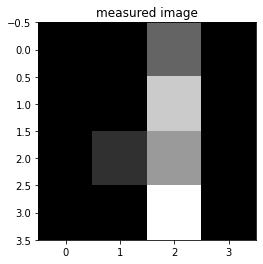

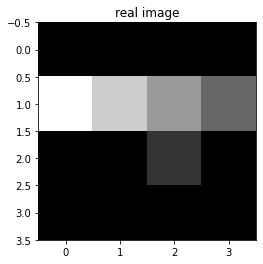

In [34]:
for theta in [90, 180, 270]:
    print('ROTATION FOR {} DEGREES'.format(theta))
    qc = rotate_circ(theta)
    output_im = simulate(qc, input_im, 100000, 0)
    plot_to_compare(output_im, input_im)